Arpitha Gurumurthy </br>
Team: Amalgam
# **Factor: Style Based approaches for fake news detection**
There are mainly two typical categories of style-based
methods: 
* Deception-oriented
  * Deception-oriented stylometric methods capture the
deceptive statements or claims from news content.
  * Rhetorical structure theory can be utilized to capture
the differences between deceptive and truthful sentences
* Rhetoric - language designed to have a persuasive or impressive effect on its audience, but often regarded as lacking in sincerity or meaningful content
*  Objectivity-oriented
  * Objectivity-oriented approaches capture style signals
that can indicate a decreased objectivity of news content
and thus the potential to mislead consumers, such
as hyperpartisan styles and yellow-journalism.



### Micro factors for Style based based on the above stated points:
* Hyperpartisan: Extremely one sided
* Yellow Journalism: relying on eye-catching headlines
* Rhetorical structure theory (for future work)

### Articles for reference:
* https://arxiv.org/pdf/1708.01967.pdf
* https://arxiv.org/pdf/1702.05638.pdf


This notebook focuses on implementing the microsfactor - yellow journalism.
### Yellow Journalism:
* Yellow journalism is the use of sensationalized news in newspaper published to attract readers and increase circulation.
* journalism that is based upon sensationalism and crude exaggeration.
* present little or no legitimate, well-researched news while instead using eye-catching headlines for increased sales. Techniques may include **exaggerations** of news events, **scandal-mongering**, or **sensationalism**


Using Textstat for feature engineering - Textstat is an easy to use library to calculate statistics from text. It helps determine readability, complexity, and grade level.



## Opening from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/Pickle_Models

/content/gdrive/My Drive/Pickle_Models


In [ ]:
!ls

deception_model.sav  finalized_model_1.sav  model_yellowness.sav


In [ ]:
pip install textstat

     |████████████████████████████████| 102kB 3.5MB/s 
     |████████████████████████████████| 1.9MB 7.4MB/s 


In [ ]:
#Importing data from google sheets - politifact dataset
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
import textstat
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ9xbQF0uRmyBhtehROE5uTac8JbvNd-jq-NMD99y6HVuungzxDuftmYiY74ZWrenpLyDFtGToiFeMo/pub?gid=745557768&single=true&output=csv')
data = r.content
df_validation = pd.read_csv(BytesIO(data))

In [ ]:
df_validation.head()

,Headline,Source,Posted,Link,Summary
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is..."
1,"Man who allegedly told U.S. Olympian ""go home,...",Newsweek,2 hours ago,https://www.newsweek.com/california-man-attack...,NaN
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap..."


In [ ]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361 entries, 0 to 1360
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  1361 non-null   object
 1   Source    1361 non-null   object
 2   Posted    1361 non-null   object
 3   Link      1361 non-null   object
 4   Summary   1358 non-null   object
dtypes: object(5)
memory usage: 53.3+ KB


In [ ]:
df_validation.shape

(1361, 5)

In [ ]:
df_validation.isna().sum()

Headline    0
Source      0
Posted      0
Link        0
Summary     3
dtype: int64

In [ ]:
df_validation = df_validation.dropna()
df_validation.isna().sum()

Headline    0
Source      0
Posted      0
Link        0
Summary     0
dtype: int64

## **EDA and Feature Engineering**

### **Latent Variables for calculating yellowness index**

In [ ]:
type(df_validation['Summary'][0])

str

In [ ]:
##Making sure Summary is of type String to apple further string operations
df_validation.Summary = df_validation.Summary.apply(str)

Textstat - Flesch Reading Ease
Returns the Flesch Reading Ease Score.

The following table defines the values for the same.

The table is an example of values. While the maximum score is 121.22, there is no limit on how low the score can be. A negative score is also valid.

Score	Difficulty:

* 90-100	Very Easy
* 80-89	Easy
* 70-79	Fairly Easy
* 60-69	Standard
* 50-59	Fairly Difficult
* 30-49	Difficult
* 0-29	Very Confusing

In [ ]:
##Creating a feature to score the text with a readability factor
df_validation['flesch_index'] = df_validation['Summary'].apply(textstat.flesch_reading_ease)

In [ ]:
##Since the flesch reading score is now inversely proportional to the yellowness factor
##we substract its value from the highest - 121.22
df_validation['flesch_index'] = 121.22 - df_validation['flesch_index'] 

In [ ]:
#function to find if string contains a question and if so, create new feature with a 1 for yes or 0 for no
question_words = ['who','what','where','why','when','whose','whom','would','will','how','which','should','could']

def is_question(text):
    if "?" in text or text.startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','did','do')):
        return 1
    else: 
        return 0
df_validation['text_lower']=df_validation['Summary'].apply(lambda x: x.lower())
df_validation['is_q']=df_validation['text_lower'].apply(is_question)
df_validation = df_validation.drop(columns='text_lower')

In [ ]:
df_validation['is_q'].value_counts()

0    1239
1     119
Name: is_q, dtype: int64

In [ ]:
#create function to find if headline contains '!' and create new feature with 1 for yes and 0 for no
def is_exclamation(headline):
    if "!" in headline: 
        return 1
    else: 
        return 0
df_validation['is_exclam']=df_validation['Summary'].apply(is_exclamation)

In [ ]:
df_validation['is_exclam'].value_counts()

0    1325
1      33
Name: is_exclam, dtype: int64

In [ ]:
#create function to find if headline contains '$' and create new feature with 1 for yes and 0 for no
def is_money_related(headline):
    if "$" in headline: 
        return 1
    else: 
        return 0
df_validation['is_money']=df_validation['Summary'].apply(is_money_related)

In [ ]:
df_validation['is_money'].value_counts()

0    1202
1     156
Name: is_money, dtype: int64

In [ ]:
#create function to find if headline starts with a digit and create new feature with 1 for yes and 0 for no
def starts_with_num(text):
    if text.startswith(('1','2','3','4','5','6','7','8','9')): 
        return 1
    else: 
        return 0

df_validation['starts_num']=df_validation['Summary'].apply(starts_with_num)

In [ ]:
df_validation['starts_num'].value_counts()

0    1319
1      39
Name: starts_num, dtype: int64

In [ ]:
##Calculating the number of words in each text 
df_validation['num_words'] = df_validation['Summary'].apply(lambda x: len(x.split()))

In [ ]:
##testing function for number of ALL CAPS words in each text
sum(map(str.isupper, df_validation['Summary'][10].split())) 

0

In [ ]:
##Creating a new feature to store the number of ALL CAPS words in each text
df_validation['All_Caps'] = df_validation['Summary'].apply(lambda x: sum(map(str.isupper, x.split())))

In [ ]:
df_validation['All_Caps'].value_counts()

0     279
1     232
2     215
3     183
4     117
5     102
6      60
7      49
8      32
9      28
12     13
10      9
11      9
13      7
15      4
14      3
18      3
16      2
17      2
19      2
66      1
20      1
24      1
30      1
35      1
43      1
88      1
Name: All_Caps, dtype: int64

In [ ]:
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1


Calculating the Sentiment score for each record

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
##Looping to pass every headline into the analyser, a sentiment score is assigned to each headline.
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for headline in df_validation['Summary']:
    pol_score = sia.polarity_scores(headline)
    pol_score['headline'] = headline
    results.append(pol_score)

results

[{'compound': -0.8779,
  'headline': 'Uttar Pradesh, India\'s most populous state, is among the worst affected in the country and its people are suffering even as authorities insist the situation is under control, reports the BBC\'s Geeta Pandey.\nWith 240 million people, Uttar Pradesh is India\'s most populous state.\nOver the past few days, I have spoken to dozens of people from across the state, and heard grim stories.\nFrom Lucknow, 62-year-old Ajay Singh sent me his wife\'s positive test report which finds no mention in the state records.\nAnshuman Rai, director of Heritage Hospitals - a private group that runs medical collages and hospitals in the state - describes the situation as "extraordinary".',
  'neg': 0.125,
  'neu': 0.844,
  'pos': 0.031},
 {'compound': -0.8715,
  'headline': 'A Corona man accused of physically assaulting a Korean American couple and threatening a Japanese American Olympic athlete has been arrested by Orange police, authorities said Monday.\nKokumai, an 

In [ ]:
##Concatenating this list to our original dataframe, only interested in the values of the ‘compound’ variable.
df_validation['Sentiment_Score'] = pd.DataFrame(results)['compound']

In [ ]:
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076


## **Defining the Yellowness quotient**


* **flesch_reading_ease** : tells us how convoluted the sentence is. The more confusing the sentence is, the more is its yellowness. We divide the value by 10 and add it towards the yellowness score.
* **is_q** : Tells us whether the text contains a question. More the questions, more the yellowness. This features gets a weight of 5.
* **is_exclam** : Tells us whether the text contains an exclamation. This features gets a weight of 10.
* **is_money** : Tells us whether the text has money relation information. This features gets a weight of 5.
* **starts_num** : Tells us whether if the text start with a number. This features gets a weight of 5.
* **All_Caps** : Tells us whether if the text contains all uppercase words. This features gets a weight of 20, since it depicts sensationalism.
* **Sentiment_Score** : A lot of emotion is captured in sensationalized text. We take the magnitude (postive and negative) of this score and add it to yellowness score.


In [ ]:
##Calculating the yellowness factor
df_validation['yellowness'] = df_validation['flesch_index']/10 \
                              + df_validation['is_q'] * 5 \
                              + df_validation['is_exclam'] * 10 \
                              + df_validation['is_money'] * 5 \
                              + df_validation['starts_num'] * 5 \
                              + df_validation['All_Caps'] * 20 \
                              + abs(df_validation['Sentiment_Score']) * 100
                              

In [ ]:
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779,114.091
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783,164.293
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000,130.414
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838,108.232
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076,77.243


Segmenting the yellowness factor into 3 categories

In [ ]:
yellowness_factor = ['Least yellow', 'Moderately Yellow', 'Highly yellow']
df_validation['yellow_factor'] = pd.qcut(df_validation['yellowness'], q=3, labels= yellowness_factor)
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness,yellow_factor
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779,114.091,Moderately Yellow
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783,164.293,Highly yellow
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000,130.414,Moderately Yellow
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838,108.232,Moderately Yellow
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076,77.243,Least yellow


## **Visualizations**

In [ ]:
len(df_validation['Source'].unique())

399

In [ ]:
##Creating a dataframe with unique sources and its average yellowness values
yellowness_df_source = (
    df_validation
    .groupby('Source')
    .agg({"yellowness":"mean"})
    .sort_values('yellowness', ascending=False)
    .reset_index()
)

# ##Creating a dataframe with unique authors and its average yellowness values
# yellowness_df_author = (
#     df_politifact
#     .groupby('Author')
#     .agg({"yellowness":"mean"})
#     .sort_values('yellowness', ascending=False)
#     .reset_index()
# )

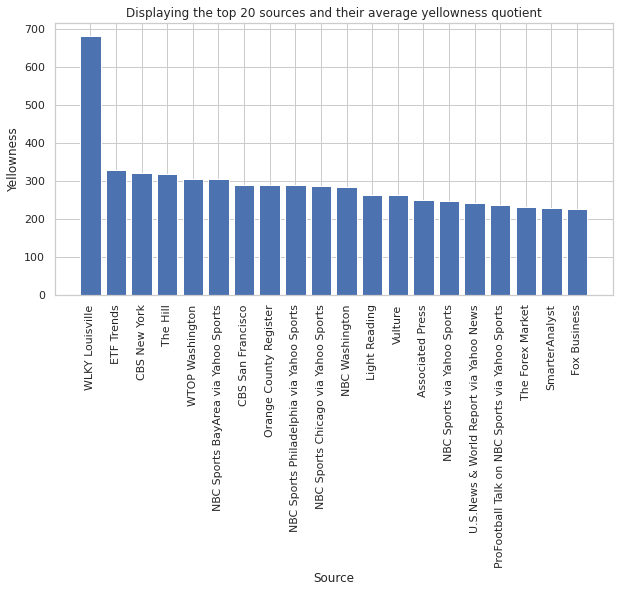

In [ ]:
##Displaying the top 20 sources and their average yellowness quotient
plt.figure(figsize=(10,5))
test_df = yellowness_df_source.head(20)
plt.bar(test_df['Source'], test_df['yellowness'])
plt.xticks(rotation=90)
plt.title('Displaying the top 20 sources and their average yellowness quotient')
plt.xlabel('Source')
plt.ylabel('Yellowness')
plt.show()

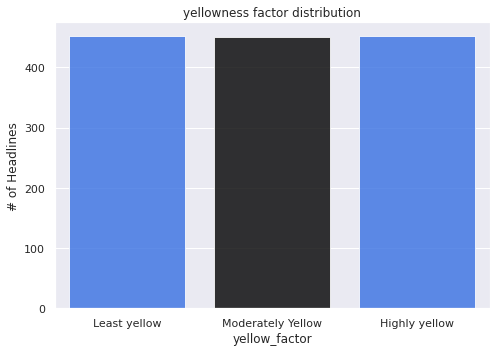

In [ ]:
#yellow_factor countplot
#visualizing yellow_factor frequency of dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(df_validation['yellow_factor'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('yellowness factor distribution')
plt.ylabel('# of Headlines')
plt.tight_layout()
plt.show()

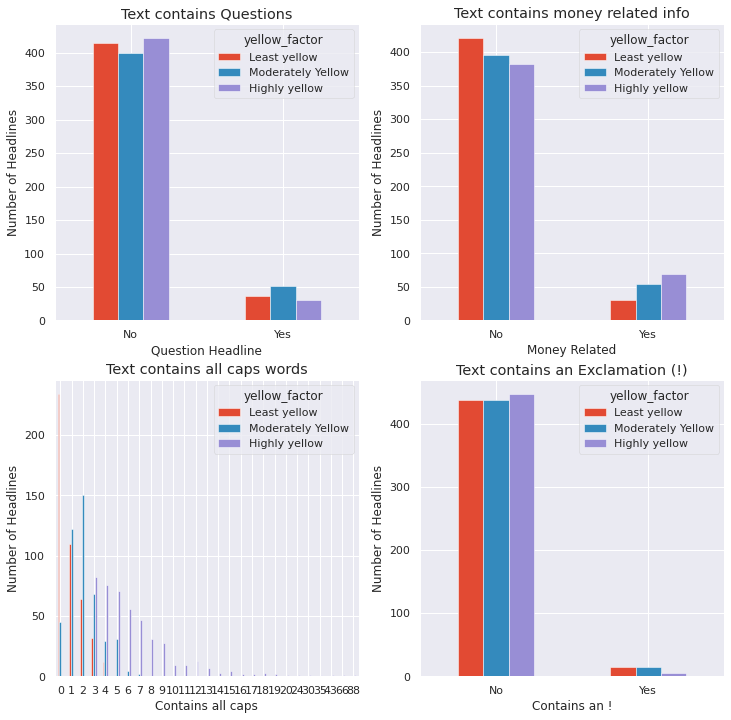

In [ ]:
#plotting engineered features to compare by yellow_factor 
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style('darkgrid')

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

plot = df_validation.groupby('is_q')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains Questions')

plot = df_validation.groupby('is_money')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Money Related')
plot.set(xticklabels=['No','Yes'])
plot.set_ylabel('Number of Headlines')
plot.set_title('Text contains money related info')

plot = df_validation.groupby('All_Caps')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Contains all caps')
plot.set_ylabel('Number of Headlines')
# plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains all caps words')

plot = df_validation.groupby('is_exclam')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains an Exclamation (!)')

style.use('ggplot')
plt.show()

## **Modeling**
### **Implementing muller loop**




In [ ]:
#Importing required libraries
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
## Function to run various algorithms to find the best fit on our data
def muller_loop(muller_df):
  df_compare_muller = pd.DataFrame(columns=['Classifier','Accuracy/Score', 'Training Time'])
  import time as time
  import xgboost as xgb
  names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
          "Naive Bayes", "QDA", "MLP"]

  classifiers = [
      KNeighborsClassifier(2),
      SVC(kernel="linear", C=0.025),
      SVC(gamma=2, C=1),
      DecisionTreeClassifier(max_depth=5),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      MLPClassifier(alpha=1, max_iter=1000),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis(),
      MLPClassifier()]

  X = df_politifact[['flesch','is_q','is_exclam','is_money','starts_num','All_Caps','num_words','Sentiment_Score']]
  y = df_politifact[['yellow_factor']]
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

  max_score = 0.0
  max_class = ''
  clf_best = ""
  model = ""
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      start_time = time.time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
      training_time = time.time() - start_time
      df_compare_muller.loc[-1] = [name, score, training_time]  # adding a row
      df_compare_muller.index = df_compare_muller.index + 1  # shifting index
      df_compare_muller = df_compare_muller.sort_index()

      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name
  print(df_compare_muller)
  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  print(80*'-' )
  print('Printing the confusion matrix for'+max_class)
  plot_confusion_matrix(clf_best, X_test, y_test, values_format=".1f", cmap=plt.cm.Reds)  
  plt.show()

  y_pred = clf_best.predict(X_test)
  print('Printing the Classification report for'+max_class)
  print(80*'-' )
  print(classification_report(y_test, y_pred))
  return df_compare_muller


Classifier = Nearest Neighbors, Score (test, accuracy) = 98.11, Training time = 0.07 seconds
Classifier = Linear SVM, Score (test, accuracy) = 69.33, Training time = 0.37 seconds
Classifier = RBF SVM, Score (test, accuracy) = 98.67, Training time = 0.26 seconds
Classifier = Decision Tree, Score (test, accuracy) = 97.67, Training time = 0.01 seconds
Classifier = Random Forest, Score (test, accuracy) = 79.22, Training time = 0.03 seconds
Classifier = Neural Net, Score (test, accuracy) = 98.78, Training time = 2.36 seconds
Classifier = AdaBoost, Score (test, accuracy) = 79.33, Training time = 0.41 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 81.56, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 60.33, Training time = 0.01 seconds
Classifier = MLP, Score (test, accuracy) = 99.56, Training time = 2.94 seconds
          Classifier  Accuracy/Score  Training Time
0                MLP       99.555556       2.940278
1                QDA       60.333333     

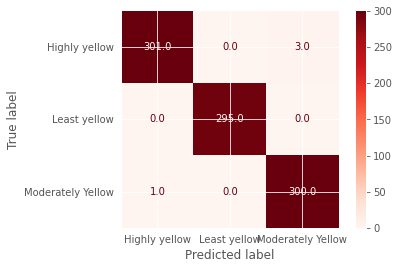

Printing the Classification report forMLP
--------------------------------------------------------------------------------
                   precision    recall  f1-score   support

    Highly yellow       1.00      0.99      0.99       304
     Least yellow       1.00      1.00      1.00       295
Moderately Yellow       0.99      1.00      0.99       301

         accuracy                           1.00       900
        macro avg       1.00      1.00      1.00       900
     weighted avg       1.00      1.00      1.00       900



,Classifier,Accuracy/Score,Training Time
0,MLP,99.555556,2.940278
1,QDA,60.333333,0.009086
2,Naive Bayes,81.555556,0.007264
3,AdaBoost,79.333333,0.408696
4,Neural Net,98.777778,2.365118
5,Random Forest,79.222222,0.033180
6,Decision Tree,97.666667,0.009792
7,RBF SVM,98.666667,0.255848
8,Linear SVM,69.333333,0.369573
9,Nearest Neighbors,98.111111,0.071803


In [ ]:
muller_loop(df_politifact)

## **Latent variables for deception detection**

In [ ]:
##Creating a feature to count the number of words
df_validation['lex_count'] = df_validation['Summary'].apply(textstat.lexicon_count)

In [ ]:
##Creating a feature to count the number of difficult words
df_validation['difficult_count'] = df_validation['Summary'].apply(textstat.difficult_words)

In [ ]:
##Creating a feature to count the number of sentences
df_validation['num_sentences'] = df_validation['Summary'].apply(textstat.sentence_count)

In [ ]:
##Creating a feature to count the number of syllable
df_validation['num_syllables'] = df_validation['Summary'].apply(textstat.syllable_count)

In [ ]:
##Creating a feature for flesch_kincaid_grade
df_validation['flesch_kincaid_grade'] = df_validation['Summary'].apply(textstat.flesch_kincaid_grade)

In [ ]:
##The Fog Scale (Gunning FOG Formula)
df_validation['gunning_fog'] = df_validation['Summary'].apply(textstat.gunning_fog)

In [ ]:
##Creating a feature for avg number of syllables per word - 
df_validation['avg_syllables'] = df_validation['num_syllables'] / df_validation['lex_count']

In [ ]:
## Average sentence length
df_validation['avg_sentence_length'] = df_validation['lex_count'] / df_validation['num_sentences']

In [ ]:
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness,yellow_factor,lex_count,difficult_count,num_sentences,num_syllables,flesch_kincaid_grade,gunning_fog,avg_syllables,avg_sentence_length
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779,114.091,Moderately Yellow,107,24,5,162,10.5,12.67,1.514019,21.4
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783,164.293,Highly yellow,115,25,5,169,11.1,13.37,1.469565,23.0
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000,130.414,Moderately Yellow,105,21,5,142,9.1,10.30,1.352381,21.0
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838,108.232,Moderately Yellow,119,19,5,152,9.0,10.53,1.277311,23.8
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076,77.243,Least yellow,116,20,5,175,11.2,14.45,1.508621,23.2


## **Defining the Deceptiveness quotient**

* **avg_sentence_length** : tells us the average number of words in each sentence of the text. 
* **avg_syllables** : tells us the average number of syllables in each word of the text.
* **flesch_kincaid_grade** : 
* **gunning_fog** : takes difficult words into account 
* **Sentiment_Score** : We take the magnitude (postive and negative) of this score and add it to deception score.


***Lower the deception_score - more decieving it is***



In [ ]:
## Score for deception
df_validation['deception_score']= df_validation['avg_sentence_length'] + df_validation['avg_syllables'] * 10 - df_validation['flesch_kincaid_grade'] - df_validation['gunning_fog'] + abs(df_validation['Sentiment_Score'])
# df_validation['deception_score']= df_validation['avg_sentence_length'] - df_validation['avg_syllables'] * 10 - df_validation['flesch_kincaid_grade'] - df_validation['gunning_fog'] + abs(df_validation['Sentiment_Score'])

In [ ]:
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness,yellow_factor,lex_count,difficult_count,num_sentences,num_syllables,flesch_kincaid_grade,gunning_fog,avg_syllables,avg_sentence_length,deception_score
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779,114.091,Moderately Yellow,107,24,5,162,10.5,12.67,1.514019,21.4,14.248087
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783,164.293,Highly yellow,115,25,5,169,11.1,13.37,1.469565,23.0,14.003952
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000,130.414,Moderately Yellow,105,21,5,142,9.1,10.30,1.352381,21.0,15.123810
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838,108.232,Moderately Yellow,119,19,5,152,9.0,10.53,1.277311,23.8,18.026909
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076,77.243,Least yellow,116,20,5,175,11.2,14.45,1.508621,23.2,13.143807


In [ ]:
deceptiveness_factor = ['Deceptive', 'Not Deceptive']
df_validation['deceptiveness_factor'] = pd.qcut(df_validation['deception_score'], q=2, labels= deceptiveness_factor)
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness,yellow_factor,lex_count,difficult_count,num_sentences,num_syllables,flesch_kincaid_grade,gunning_fog,avg_syllables,avg_sentence_length,deception_score,deceptiveness_factor
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779,114.091,Moderately Yellow,107,24,5,162,10.5,12.67,1.514019,21.4,14.248087,Deceptive
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783,164.293,Highly yellow,115,25,5,169,11.1,13.37,1.469565,23.0,14.003952,Deceptive
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000,130.414,Moderately Yellow,105,21,5,142,9.1,10.30,1.352381,21.0,15.123810,Not Deceptive
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838,108.232,Moderately Yellow,119,19,5,152,9.0,10.53,1.277311,23.8,18.026909,Not Deceptive
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076,77.243,Least yellow,116,20,5,175,11.2,14.45,1.508621,23.2,13.143807,Deceptive


In [ ]:
##Creating a dataframe with unique sources and its average deceptive values
deceptiveness_df_source = (
    df_validation
    .groupby('Source')
    .agg({"deception_score":"mean"})
    .sort_values('deception_score', ascending=False)
    .reset_index()
)

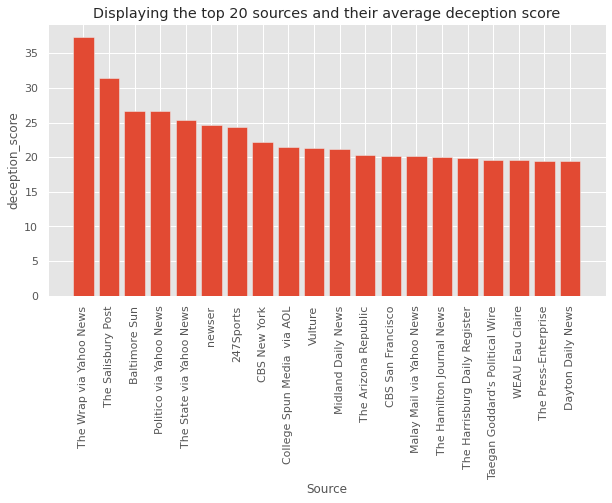

In [ ]:
##Displaying the top 20 sources and their average yellowness quotient
plt.figure(figsize=(10,5))
test_df = deceptiveness_df_source.head(20)
plt.bar(test_df['Source'], test_df['deception_score'])
plt.xticks(rotation=90)
plt.title('Displaying the top 20 sources and their average deception score')
plt.xlabel('Source')
plt.ylabel('deception_score')
plt.show()

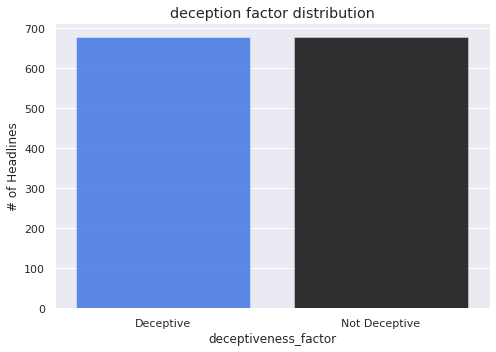

In [ ]:
#deceptiveness_factor countplot
#visualizing deceptiveness_factor frequency of dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(df_validation['deceptiveness_factor'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('deception factor distribution')
plt.ylabel('# of Headlines')
plt.tight_layout()
plt.show()

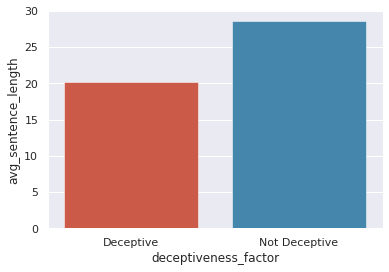

In [ ]:
##Creating a dataframe with unique sources and its average deceptive values
deceptiveness_df_avgSent = (
    df_validation
    .groupby('deceptiveness_factor')
    .agg({"avg_sentence_length":"mean"})
    .sort_values('avg_sentence_length', ascending=False)
    .reset_index()
)
ax = sns.barplot(x="deceptiveness_factor", y="avg_sentence_length", data=deceptiveness_df_avgSent)

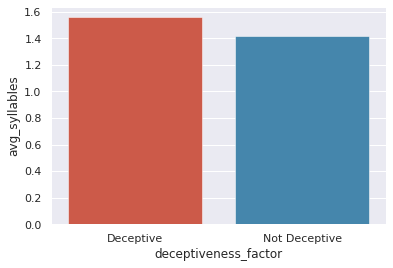

In [ ]:
##Creating a dataframe with unique sources and its average deceptive values
deceptiveness_df_avgSyllables = (
    df_validation
    .groupby('deceptiveness_factor')
    .agg({"avg_syllables":"mean"})
    .sort_values('avg_syllables', ascending=False)
    .reset_index()
)
ax = sns.barplot(x="deceptiveness_factor", y="avg_syllables", data=deceptiveness_df_avgSyllables)

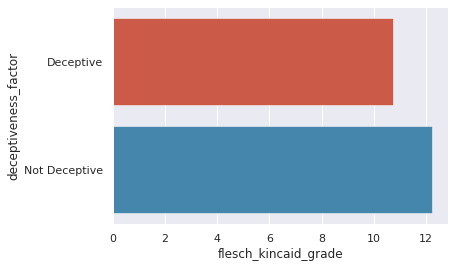

In [ ]:
##Creating a dataframe with unique sources and its average deceptive values
deceptiveness_df_flesch_kincaid_grade = (
    df_validation
    .groupby('deceptiveness_factor')
    .agg({"flesch_kincaid_grade":"mean"})
    .sort_values('flesch_kincaid_grade', ascending=False)
    .reset_index()
)
ax = sns.barplot(x="flesch_kincaid_grade", y="deceptiveness_factor", data=deceptiveness_df_flesch_kincaid_grade)

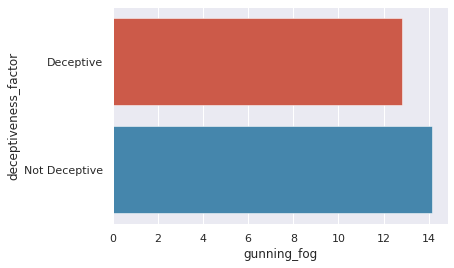

In [ ]:
##Creating a dataframe with unique sources and its average deceptive values
deceptiveness_df_gunning_fog = (
    df_validation
    .groupby('deceptiveness_factor')
    .agg({"gunning_fog":"mean"})
    .sort_values('gunning_fog', ascending=False)
    .reset_index()
)
ax = sns.barplot(x="gunning_fog", y="deceptiveness_factor", data=deceptiveness_df_gunning_fog)

## **Define factor - style based**

In [ ]:
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness,yellow_factor,lex_count,difficult_count,num_sentences,num_syllables,flesch_kincaid_grade,gunning_fog,avg_syllables,avg_sentence_length,deception_score,deceptiveness_factor
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779,114.091,Moderately Yellow,107,24,5,162,10.5,12.67,1.514019,21.4,14.248087,Deceptive
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783,164.293,Highly yellow,115,25,5,169,11.1,13.37,1.469565,23.0,14.003952,Deceptive
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000,130.414,Moderately Yellow,105,21,5,142,9.1,10.30,1.352381,21.0,15.123810,Not Deceptive
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838,108.232,Moderately Yellow,119,19,5,152,9.0,10.53,1.277311,23.8,18.026909,Not Deceptive
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076,77.243,Least yellow,116,20,5,175,11.2,14.45,1.508621,23.2,13.143807,Deceptive


In [ ]:
df_validation['style_score'] = df_validation['yellowness'] / df_validation['deception_score']

In [ ]:
df_validation = df_validation.dropna()

***Higher the target value - says that the style is bad***

In [ ]:
Style_factor = ['Good Style', 'Neutral Style', 'Bad Style']
df_validation['target'] = pd.qcut(df_validation['style_score'], q=3, labels= Style_factor)
df_validation.head()

,Headline,Source,Posted,Link,Summary,flesch_index,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness,yellow_factor,lex_count,difficult_count,num_sentences,num_syllables,flesch_kincaid_grade,gunning_fog,avg_syllables,avg_sentence_length,deception_score,deceptiveness_factor,target,style_score
0,Covid in Uttar Pradesh: Coronavirus overwhelms...,BBC via Yahoo News,4 hours ago,https://news.yahoo.com/covid-uttar-pradesh-cor...,"Uttar Pradesh, India's most populous state, is...",63.01,0,0,0,0,109,1,-0.8779,114.091,Moderately Yellow,107,24,5,162,10.5,12.67,1.514019,21.4,14.248087,Deceptive,Neutral Style,8.007461
2,Corona man arrested after punching Asian Ameri...,KTLA-TV Los Angeles,21 hours ago,https://ktla.com/news/local-news/corona-man-ar...,A Corona man accused of physically assaulting ...,64.63,0,0,0,0,115,4,0.7783,164.293,Highly yellow,115,25,5,169,11.1,13.37,1.469565,23.0,14.003952,Deceptive,Bad Style,11.731902
3,What should investors do after the 4600-point ...,MSN News,6 hours ago,https://www.msn.com/en-in/money/topstories/wha...,© Kshitij Anand What should investors do after...,54.14,1,0,0,0,105,6,0.0000,130.414,Moderately Yellow,105,21,5,142,9.1,10.30,1.352381,21.0,15.123810,Not Deceptive,Neutral Style,8.623092
4,Construction starts on 91-15 freeways toll-lan...,The Press-Enterprise,18 hours ago,https://www.pe.com/2021/04/19/construction-sta...,"Construction was set to start Monday night, Ap...",48.52,0,0,1,0,119,0,-0.9838,108.232,Moderately Yellow,119,19,5,152,9.0,10.53,1.277311,23.8,18.026909,Not Deceptive,Good Style,6.003913
5,"Man, 25, arrested for allegedly assaulting eld...",NY Daily News via AOL,18 hours ago,https://www.aol.com/man-25-arrested-allegedly-...,A 25-year-old man has been arrested for allege...,64.83,0,0,0,0,116,1,0.5076,77.243,Least yellow,116,20,5,175,11.2,14.45,1.508621,23.2,13.143807,Deceptive,Good Style,5.876760


## **Modeling**
### **Implementing muller loop**




In [ ]:
#Importing required libraries
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
## Function to run various algorithms to find the best fit on our data
def muller_loop(muller_df):
  df_compare_muller = pd.DataFrame(columns=['Classifier','Accuracy/Score', 'Training Time'])
  import time as time
  import xgboost as xgb
  names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
          "Naive Bayes", "QDA", "MLP"]

  classifiers = [
      KNeighborsClassifier(2),
      SVC(kernel="linear", C=0.025),
      SVC(gamma=2, C=1),
      DecisionTreeClassifier(max_depth=5),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      MLPClassifier(alpha=1, max_iter=1000),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis(),
      MLPClassifier()]
  X = df_politifact[['flesch','is_q','is_exclam','is_money','starts_num','All_Caps','num_words','Sentiment_Score','avg_sentence_length','avg_syllables','flesch_kincaid_grade','gunning_fog']]
  y = df_politifact[['target']]
  X = StandardScaler().fit_transform(X)
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

  max_score = 0.0
  max_class = ''
  clf_best = ""
  model = ""
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      start_time = time.time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
      training_time = time.time() - start_time
      df_compare_muller.loc[-1] = [name, score, training_time]  # adding a row
      df_compare_muller.index = df_compare_muller.index + 1  # shifting index
      df_compare_muller = df_compare_muller.sort_index()

      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name
  print(df_compare_muller)
  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  print(80*'-' )
  print('Printing the confusion matrix for'+max_class)
  plot_confusion_matrix(clf_best, X_test, y_test, values_format=".1f", cmap=plt.cm.Reds)  
  plt.show()

  y_pred = clf_best.predict(X_test)
  print('Printing the Classification report for'+max_class)
  print(80*'-' )
  print(classification_report(y_test, y_pred))
  return df_compare_muller


In [ ]:
import pickle
# load the model from disk
X_test = df_validation[['flesch_index','is_q','is_exclam','is_money','starts_num','All_Caps','num_words','Sentiment_Score']]
Y_test = df_validation[['yellow_factor']]

filename='finalized_model_1.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

In [ ]:
print("The accuracy for yellowness detection on yahoo news using MLP is:",result)

The accuracy for yellowness detection on yahoo news using MLP is: 0.6383763837638377


In [ ]:
# load the model from disk
X_test = df_validation[['avg_sentence_length','avg_syllables','flesch_kincaid_grade','gunning_fog','Sentiment_Score']]
Y_test = df_validation[['deceptiveness_factor']]

filename='deception_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

In [ ]:
print("The accuracy for yellowness detection on yahoo news using MLP is:", result)

The accuracy for yellowness detection on yahoo news using MLP is: 0.5003690036900369


## **References**
* https://algotrading101.com/learn/sentiment-analysis-python-guide/
* https://github.com/Lucas170/Sentiment-Analysis-1-TSLA-Headlines
* https://github.com/AlisonSalerno/clickbait_detector
* https://github.com/aarsanjani/applied-ml-2020/blob/master/MullerLoop.ipynb
* https://github.com/dhrushilbadani/YellowFever
* https://pypi.org/project/textstat/

